In [1]:
# Data import

import pandas as pd
df = pd.read_csv("/content/2023-12-15_15_41-results.csv", usecols = ['time', 'dist','avgSnr', 'aod_theta', 'aoa_theta', 'avg_pl'])

# Display first five and last five rows of the dataset
# pd.concat([df.head(), df.tail()])

df.describe()

,time,dist,avgSnr,avg_pl,aod_theta,aoa_theta
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,254.400000,122.859582,-6.319092,74.081458,1.585576,-1.556028
std,123.379739,133.000541,0.933387,6.681483,0.511113,0.511103
min,41.000000,31.019154,-9.448666,68.205118,1.091973,-2.049623
25%,147.700000,33.319540,-6.921546,70.345333,1.165680,-1.975916
50%,254.400000,33.559771,-6.224673,71.167304,1.166223,-1.975373
75%,361.100000,202.299475,-5.516558,74.363486,2.219096,-0.922516
max,467.800000,457.161680,-4.660743,100.684175,2.309710,-0.831921


In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

df = pd.read_csv("/content/2023-12-15_15_41-results.csv", usecols = ['time', 'dist','avgSnr', 'aod_theta', 'aoa_theta', 'avg_pl'])

data = df['avgSnr'].values[:100]

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data, seq_length)

# Convert data to PyTorch tensors
trainX = torch.tensor(X[:, :, None], dtype=torch.float32)
trainY = torch.tensor(y[:, None], dtype=torch.float32)


In [4]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # If hidden and cell states are not provided, initialize them as zeros
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)

        # Forward pass through LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Selecting the last output
        return out, hn, cn


In [7]:
# Initialize model, loss, and optimizer
model = LSTMModel(input_dim=1, hidden_dim=50, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [8]:
# Training loop
num_epochs = 4000
h0, c0 = None, None  # Initialize hidden and cell states

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs, h0, c0 = model(trainX, h0, c0)

    # Compute loss
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    # Detach hidden and cell states to prevent backpropagation through the entire sequence
    h0 = h0.detach()
    c0 = c0.detach()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/4000], Loss: 1.0986
Epoch [20/4000], Loss: 1.7958
Epoch [30/4000], Loss: 1.0524
Epoch [40/4000], Loss: 0.9642
Epoch [50/4000], Loss: 0.9788
Epoch [60/4000], Loss: 0.9421
Epoch [70/4000], Loss: 0.9377
Epoch [80/4000], Loss: 0.9385
Epoch [90/4000], Loss: 0.9374
Epoch [100/4000], Loss: 0.9364
Epoch [110/4000], Loss: 0.9357
Epoch [120/4000], Loss: 0.9346
Epoch [130/4000], Loss: 0.9323
Epoch [140/4000], Loss: 0.9269
Epoch [150/4000], Loss: 0.9186
Epoch [160/4000], Loss: 0.9017
Epoch [170/4000], Loss: 0.8679
Epoch [180/4000], Loss: 0.7720
Epoch [190/4000], Loss: 0.5437
Epoch [200/4000], Loss: 0.3754
Epoch [210/4000], Loss: 0.5821
Epoch [220/4000], Loss: 0.4198
Epoch [230/4000], Loss: 0.2670
Epoch [240/4000], Loss: 0.1536
Epoch [250/4000], Loss: 0.1154
Epoch [260/4000], Loss: 0.0839
Epoch [270/4000], Loss: 0.0681
Epoch [280/4000], Loss: 0.0565
Epoch [290/4000], Loss: 0.0482
Epoch [300/4000], Loss: 0.0421
Epoch [310/4000], Loss: 0.0374
Epoch [320/4000], Loss: 0.0338
Epoch [330/4000],

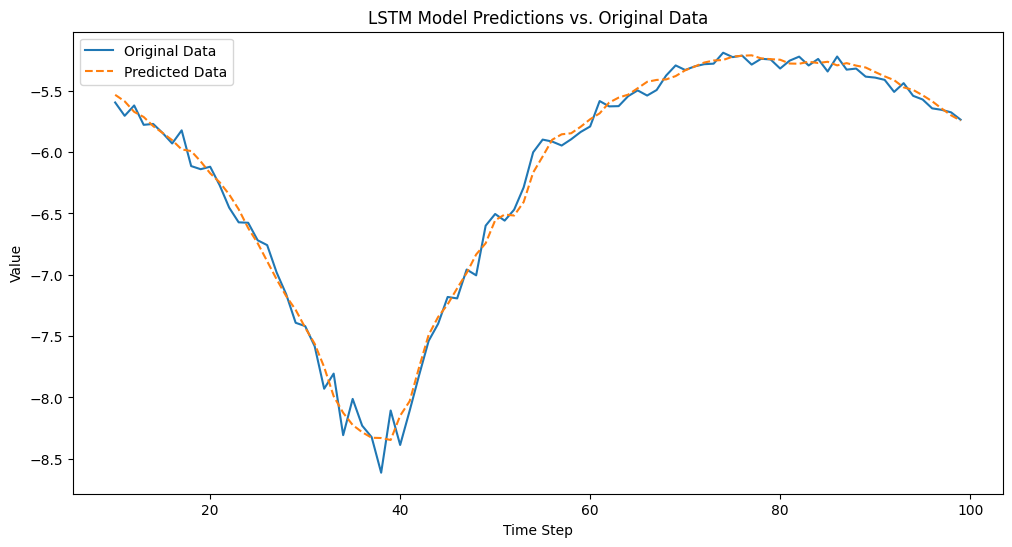

[-5.39032819 -5.38962164 -5.40509907 -5.39991918 -5.4196088  -5.41189899
 -5.47256815 -5.46114282 -5.49309815 -5.55361117 -5.59563617 -5.70435568
 -5.62010079 -5.77788625 -5.77058704 -5.84473903 -5.9298925  -5.82286152
 -6.11413063 -6.13962925 -6.11938291 -6.2704137  -6.45288962 -6.57268056
 -6.57624808 -6.71899516 -6.75850731 -6.98218442 -7.15855382 -7.39158502
 -7.41839059 -7.58249189 -7.92901888 -7.80581249 -8.30752179 -8.01211332
 -8.23016433 -8.32359613 -8.61375377 -8.10658865 -8.38747548 -8.10830663
 -7.8172644  -7.53879407 -7.39929034 -7.18114825 -7.19270202 -6.95736916
 -7.00472107 -6.60005837 -6.50466368 -6.55874317 -6.46939779 -6.28789086
 -6.00164915 -5.89828035 -5.91412778 -5.94664964 -5.89571396 -5.83620841
 -5.79131948 -5.5840051  -5.62747026 -5.62550867 -5.54423362 -5.49714265
 -5.53919961 -5.49412572 -5.3760347  -5.29365637 -5.33087334 -5.30166723
 -5.28369128 -5.279259   -5.19011375 -5.22586537 -5.21370331 -5.28685099
 -5.23957626 -5.2452034  -5.31886579 -5.2548192  -5

In [9]:
# Predicted outputs
model.eval()
predicted, _, _ = model(trainX, h0, c0)

# Adjusting the original data and prediction for plotting
original = data[seq_length:]  # Original data from the end of the first sequence
time_steps = np.arange(seq_length, len(data))  # Corresponding time steps

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, predicted.detach().numpy(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

print(data)
print(predicted.detach().numpy())